# DeepDream

We'll describe an implementation of DeepDream.

In [50]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

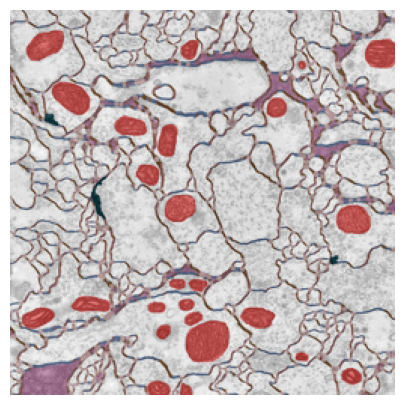

In [51]:
from PIL import Image
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1288336/preview.jpg'
im = Image.open(urlopen(url)).resize((256,256))

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 5))
plt.imshow(im)
plt.axis('off')
plt.show()

We'll download a pretrained model (VGG16) and freeze the layers

In [52]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad_(False)

print(model)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
def deepdream(im, test_layer, num_iterations=500, learning_rate=1.e0):

    import torch
    from deepdream import fwd_hook, preprocess, deprocess
    import numpy as np
    from PIL import Image

    image = preprocess(im)
    model.eval()
    for t in range(num_iterations):
 
        with fwd_hook(test_layer) as fh:
            out = model(image)
        score = fh.stored.mean()
        score.backward()
   
        image.data += learning_rate*(image.grad.data/torch.linalg.norm(image.grad.data))
        image.grad.data.zero_()

        #image.data.clamp_(min=-1, max=1)
    #return deprocess(image.data.clone().detach()), t
    return Image.fromarray(np.uint8(deprocess(image.data.clone().detach())*255), 'RGB'), t

In [ ]:
test_layer = model.features[4]
im_out, num_iter  =  deepdream(im, test_layer, num_iterations=50, learning_rate=1.e0)

We'll display the results in comparison with the original image

In [ ]:
plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_out)
plt.title(f"Iteration {num_iter+1}") 
plt.axis('off')
plt.show()

Octaves

In [ ]:
octave_scale = 1.3
im_oct = im

for n in range(-2,3):
    im_oct = im_oct.resize((int(im.size[0]*(octave_scale**n)),int(im.size[1]*(octave_scale**n))))
    print(im_oct.size)
    im_oct, _  =  deepdream(im_oct, test_layer, num_iterations=50, learning_rate=1.e0)
    plt.figure(figsize=(12, 5)) 
    plt.subplot(1, 2, 1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(im_oct, interpolation='bilinear')
    plt.title(f"Iteration {num_iter+1}") 
    plt.axis('off')
    plt.show()
    im_oct = im_oct.resize(im.size)


In [ ]:
class fwd_hooks():
    def __init__(self, ms):
        self.ms = ms
        self.hook, self.stored = [], []
        for m in self.ms:
            self.hook.append(m.register_forward_hook(self.hook_func))
    def hook_func(self, m, i, o):
        # print('Forward hook running...') 
        self.stored.append(o)
        # print(f'Activations size: {o.size()}')
    def __enter__(self, *args): 
         return self
    def __exit__(self, *args): 
        for h in self.hook:    
            h.remove() 
 

In [ ]:
def deepdream(im, test_layer, num_iterations=500, learning_rate=1.e0):

    import torch
    from deepdream import fwd_hook, preprocess, deprocess
    import numpy as np
    from PIL import Image

    image = preprocess(im)
    model.eval()
    for t in range(num_iterations):
 
        with fwd_hooks(test_layers) as fh:
            out = model(image)
        score=0    
        for f in fh.stored:
            score += f.mean() 
        score.backward()
   
        image.data += learning_rate*(image.grad.data/torch.linalg.norm(image.grad.data))
        image.grad.data.zero_()

        #image.data.clamp_(min=-1, max=1)
    #return deprocess(image.data.clone().detach()), t
    return Image.fromarray(np.uint8(deprocess(image.data.clone().detach())*255), 'RGB'), t

In [2]:
test_layers = [model.features[4]]#, model.features[16]]

im_out, num_iter  =  deepdream(im, test_layers, num_iterations=50, learning_rate=1.e0)

NameError: name 'model' is not defined

In [1]:
plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_out)
plt.title(f"Iteration {num_iter+1}") 
plt.axis('off')
plt.show()

NameError: name 'plt' is not defined